In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
! pip install wandb pytorch-lightning torchinfo

In [8]:
import torch 
from torch import nn 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import Tensor

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import numpy as np

import matplotlib.pyplot as plt
import cv2

import wandb
from typing import List


from pathlib import Path
from torchinfo import summary

## Flat internal organization from the footprint
Model takes a footprint of a flat with marked entrance and generates the internal organization of it. This project is developed in collaboration with FA student Andrei Kazlouski. 
[Project repo](https://gitlab.fit.cvut.cz/tokarart/mvi-sp)

### Data
For this project we've decided to generate our own floor plans (targets) which then will be inpainted with black color (input). For the data generation we use Grasshoper software with [DeCodingSpaces Toolbox](https://toolbox.decodingspaces.net/magnetizing-floor-plan-generator/). Generation is still in in progress so I will perform prototyping on different data.

We generate different types of flats (1+kk, 1+1, 2+kk etc.). Firstly we define graph with flat (example below)
<img src="https://drive.google.com/uc?export=view&id=1---AwCxJQZeTeThNmkDDTiDjgFjopebJ" alt="drawing" width="400"/>

Then it generates one sample with structure from the graph but random positioning. To speed up the generation process we generate animation with many floorplans and make screenshots of each frame. By default, library randomly selects the color of the room, which is unacceptable in our case, so we have to manually set up the colors for each type of room. 

The algorithm blueprint is shown below

<img src="https://drive.google.com/uc?export=view&id=1n0VKrmh-kRZutU6hvc2msdOQN1YD-Vys" alt="drawing" width="400"/>

For every type of flat we'll generate ~200 plans, which ain't much so I'll use augmentations (primarly rotation by 90/180/270 degrees), so the final training set will have 3 times more samples.  

Working on data generation is currently in its final stage. And I can provide already generated samples. 

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


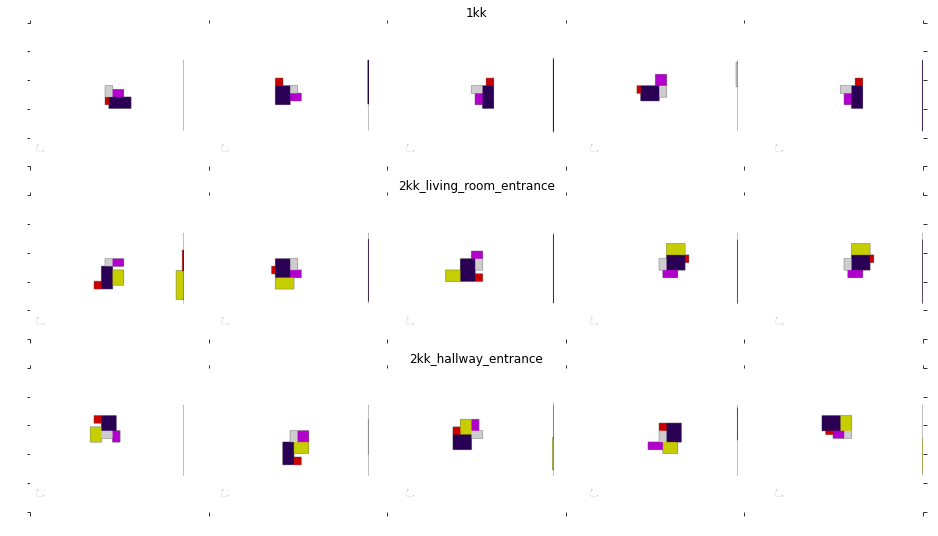

In [9]:
n_samples = 5

p = Path('/content/drive/MyDrive/UNIVERSITY/MVI/mvi-sp/samples/')

fig, big_axs = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), sharey=True)
for i, sample_p in enumerate(p.glob('[!.]*')):
    name = sample_p.name
    all_samples = list(sample_p.glob('*.png'))
    samples = np.random.choice(all_samples, size=n_samples)
    
    big_axs[i].set_title(f'{name}')
    big_axs[i].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_axs[i]._frameon = False
    for j in range(n_samples):
        img = cv2.imread(str(samples[j]))
        ax = fig.add_subplot(3, n_samples, n_samples * i + j + 1)
        ax.imshow(img)
        ax.axis('off')
# plt.tight_layout()
plt.show()

Samples has not been yet processed, so there are artifacts on it. Furthermore, the images will be cropped later.

### Papers

I've read (not completely :)) these papaers:

- [Image-to-Image Translation: Methods and Applications](https://arxiv.org/pdf/2101.08629.pdf)
- [Learning Diverse Image Colorization](https://openaccess.thecvf.com/content_cvpr_2017/papers/Deshpande_Learning_Diverse_Image_CVPR_2017_paper.pdf)
- [Infrared Image Colorization based on a Triplet DCGAN Architecture
](https://openaccess.thecvf.com/content_cvpr_2017_workshops/w3/papers/Suarez_Infrared_Image_Colorization_CVPR_2017_paper.pdf)
- [Image-to-Image Translation with Conditional Adversarial Networks
](https://arxiv.org/pdf/1611.07004.pdf)

I decided to try to use **(V)AE** architecture for this task. Since the data are not here yet, I'm gonna try to train VAE for image inpainting task on some relatively simple data. 

Last paper includes [git repo](https://github.com/phillipi/pix2pix) with the model. I'm planning to compare results of my model to this one.

## Torch

In [10]:
# constants
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data_root = '/content/drive/MyDrive/UNIVERSITY/MVI/mvi-sp/data/'

wandb_logger = WandbLogger(project="mvi_sp", save_dir='/content/drive/MyDrive/UNIVERSITY/MVI/mvi-sp', log_model='all')

image_size = (64, 64)

batch_size = 16
epochs = 50
num_workers = 2

In [11]:
trf = transforms.Compose(
    [transforms.Resize(image_size),
     transforms.ToTensor()])  

dataset = datasets.ImageFolder(data_root + 'abstract_gallery', transform=trf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [12]:
# helper functions to calculate the image size after conv/convTranspose
def compute_h_w_conv(h_in, w_in, kernel_size, stride, padding):
    h_out = (h_in + 2 * padding - kernel_size) / stride + 1
    w_out = (w_in + 2 * padding - kernel_size) / stride + 1
    return int(np.floor(h_out)), int(np.floor(w_out))

def compute_h_w_deconv(h_in, w_in, kernel_size, stride, padding, output_padding):
    h_out = (h_in - 1) * stride - 2 * padding + kernel_size - 1 + output_padding + 1
    w_out = (w_in - 1) * stride - 2 * padding + kernel_size - 1 + output_padding + 1
    return h_out, w_out

In [18]:
class SimpleVAE(pl.LightningModule):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 debug: bool = False) -> None:
        super().__init__()
        self.debug = debug
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1), # -> 64x64
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), #  32x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # ->16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        size = image_size[0] // 2**3
        self.fc_mu = nn.Linear(size * size * 64, latent_dim)
        self.fc_var = nn.Linear(size * size * 64, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, size * size * 64)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride = 2, padding=1, output_padding=1), # -> 64x64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride = 2, padding=1, output_padding=1), # 128x128
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride = 2, padding=1, output_padding=1), # 128x128
            nn.Tanh()
        )

        self.kld_weight = nn.Parameter(torch.tensor(0.5), requires_grad=False)

    def encode(self, input: Tensor) -> List[Tensor]:
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]


    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        size = int(image_size[0] / 2**3)
        result = result.view(-1, 64, size, size)
        result = self.decoder(result)
        return result


    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu


    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]
    
    
    def loss_function(self,
                      recons,
                      input,
                      mu,
                      log_var,
                      color_input):
        
        recons_loss = F.mse_loss(recons, color_input)
        # kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        kld_loss = 0  # VAE doesn't work now

        loss = recons_loss + self.kld_weight * kld_loss

        if self.debug:
            print('returning loss')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}
    
    def training_step(self, batch, batch_idx):
        if self.debug:
            print('step started')

        color_input, _ = batch
        grayscale = transforms.Grayscale(num_output_channels=3)(color_input)
        output = self.forward(grayscale)
        # output += color_input # to compute loss
        loss_dict = self.loss_function(*output, color_input)
        loss, rec_loss, KLD = loss_dict['loss'], loss_dict['Reconstruction_Loss'], loss_dict['KLD']
        
        self.log("train/loss", loss)
        self.log("train/rec_loss", rec_loss)
        # self.log("train/KLD_loss", KLD)
        
        if self.global_step % 20 == 0:
            input_image = wandb.Image(grayscale, caption='grayscale')
            output_image = wandb.Image(output[0], caption='colorized image')
            self.logger.experiment.log({'images': [input_image, output_image]})    

        return loss

    def on_epoch_start(self):
        # update KLD weight
        self.kld_weight = nn.Parameter(torch.tensor(0.0) if self.current_epoch < 10 else torch.tensor(self.current_epoch / epochs, requires_grad=False))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [19]:
# save checkpoint in W&B
callback = pl.callbacks.ModelCheckpoint(monitor='train/loss', mode='min', save_top_k=3)

In [20]:
model = SimpleVAE(3, 32)

# trainer = pl.Trainer(max_epochs=15, gpus=1, log_every_n_steps=25)
trainer = pl.Trainer(max_epochs=epochs, logger=wandb_logger, gpus=-1, log_every_n_steps=25)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [23]:
summary(model, input_size=(16, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleVAE                                --                        --
├─Sequential: 1-1                        [16, 64, 8, 8]            --
│    └─Conv2d: 2-1                       [16, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [16, 16, 32, 32]          32
│    └─LeakyReLU: 2-3                    [16, 16, 32, 32]          --
│    └─Conv2d: 2-4                       [16, 32, 16, 16]          4,640
│    └─BatchNorm2d: 2-5                  [16, 32, 16, 16]          64
│    └─LeakyReLU: 2-6                    [16, 32, 16, 16]          --
│    └─Conv2d: 2-7                       [16, 64, 8, 8]            18,496
│    └─BatchNorm2d: 2-8                  [16, 64, 8, 8]            128
│    └─LeakyReLU: 2-9                    [16, 64, 8, 8]            --
├─Linear: 1-2                            [16, 32]                  131,104
├─Linear: 1-3                            [16, 32]                  131,

In [16]:
trainer.fit(model, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 23.8 K
1 | fc_mu         | Linear     | 131 K 
2 | fc_var        | Linear     | 131 K 
3 | decoder_input | Linear     | 135 K 
4 | decoder       | Sequential | 23.6 K
---------------------------------------------
444 K     Trainable params
1         Non-trainable params
444 K     Total params
1.779     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

- Outputs and stats might be found in W&B report
- VAE didn't properly work so now left as normal AE
- Results are not really promissing, need to experiment more with VAE and GANs
- Now I finish the data generation stage, then will work on its preprocessing
- Following section is only experiment, you can skip it

## TF experiments. Skip it

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# load the data
batch_size = 32
img_height = 128
img_width = 128

# data_root = '/content/drive/MyDrive/UNIVERSITY/MVI/mvi-sp/data/'


# train_ds = tf.keras.utils.image_dataset_from_directory(
#   data_root,
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:

a = next(iter(x_train))
gr = tf.image.rgb_to_grayscale(a)
res = encoder(gr)


ValueError: ignored

In [ ]:

res[2]

NameError: ignored

In [ ]:
decoder(res[2])

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 32

# encoder
encoder_inputs = keras.Input(shape=(32, 32, 1))
x = tf.keras.layers.Normalization()(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder = keras.Model(encoder_inputs, x, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 1)    3           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 16)   160         ['normalization[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 32)     4640        ['conv2d[0][0]']                 
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 32, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 32))(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              67584     
                                                                 
 reshape (Reshape)           (None, 8, 8, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 16)       4624      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 8)        1160      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 3)        219 

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x = data
        grayscale = tf.image.rgb_to_grayscale(x)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(grayscale)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=batch_size)

Epoch 1/30


KeyboardInterrupt: ignored

In [ ]:
batch = next(iter(dataloader))[0]
img = batch[0, ...]

res, _, _, _ = model.forward(img)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(res.numpy())
axs[0].imshow(img.numpy())

In [ ]:
autoencoder = AwesoneAE.load_from_checkpoint("/Users/saladartem/Documents/FIT/Masters/MVI/mvi-sp/lightning_logs/version_5/checkpoints/epoch=24-step=23449.ckpt")

In [ ]:
encoder = autoencoder.encoder
encoder.eval()

img = np.zeros((28,28))
img[:, 18] = 1

img = img.reshape(1, 784)

code = encoder(torch.Tensor(img))

In [ ]:
decoder = autoencoder.decoder
decoder.eval()

Sequential(
  (0): Linear(in_features=10, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=784, bias=True)
)

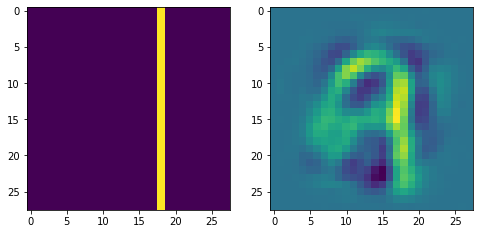

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 12))

ax[0].imshow(img.reshape(28, 28))
ax[1].imshow(decoder(code).reshape(28,28).detach().numpy())
plt.show()

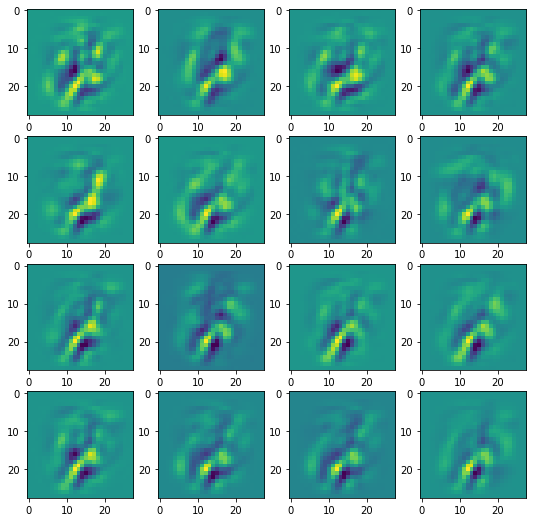

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(9,9))
for i in range(16):
    axs[i // 4][i % 4].imshow(decoder(torch.rand(1, 10)).reshape(28,28).detach().numpy())
plt.show()